In [ ]:
%%sh
pip install -qU pip sagemaker

In [17]:
import json
import pprint
import sagemaker
import boto3
from sagemaker.huggingface import HuggingFaceModel, get_huggingface_llm_image_uri
from IPython.display import display, Markdown, Image

In [2]:
role = sagemaker.get_execution_role()

# Model Deployment

In [3]:
model_id = "arcee-ai/Arcee-Spark"

hub = {
    "HF_MODEL_ID": model_id,
    'SM_NUM_GPUS': '1',
    # MAX_INPUT_TOKENS is limited by GPU RAM
    'MAX_INPUT_TOKENS': '8192',
    'MAX_TOTAL_TOKENS': '10240',
    'MESSAGES_API_ENABLED': 'true'
}

In [4]:
huggingface_model = HuggingFaceModel(
    image_uri=get_huggingface_llm_image_uri("huggingface", version="2.2.0"),
    env=hub,
    role=role
)

predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type="ml.g5.2xlarge",
    container_startup_health_check_timeout=300,
  )

-------------!

# Model Inference

In [30]:
body = {
    "model": "tgi",
    "messages": [
        {"role": "system", "content": "As a friendly technical assistant engineer, answer the question in detail."},
        {"role": "user", "content": "Why are transformers better models than LSTM?"}
    ],
    "max_tokens": 1024,
}

In [32]:
# Default settings
# Only added to jump back and forth between batch and streaming
from sagemaker.base_deserializers import JSONDeserializer

predictor.deserializer = JSONDeserializer()

response = predictor.predict(body)

In [33]:
pprint.pprint(response)

{'choices': [{'finish_reason': 'eos_token',
              'index': 0,
              'logprobs': None,
              'message': {'content': 'When comparing transformers to LSTM '
                                     "(Long Short-Term Memory) models, it's "
                                     'important to note that the choice '
                                     'between the two depends significantly on '
                                     'the specific application and the '
                                     'characteristics of the data involved. '
                                     'However, transformers, particularly due '
                                     'to their unique architecture, have '
                                     'become more popular and often outperform '
                                     'LSTMs in several tasks, primarily '
                                     'because of their ability to handle '
                                     'longer sequence

In [34]:
display(Markdown(response["choices"][0]["message"]["content"]))

When comparing transformers to LSTM (Long Short-Term Memory) models, it's important to note that the choice between the two depends significantly on the specific application and the characteristics of the data involved. However, transformers, particularly due to their unique architecture, have become more popular and often outperform LSTMs in several tasks, primarily because of their ability to handle longer sequences and their efficiency in processing parallelizable tasks. Here are some key reasons why transformers might be considered better for certain scenarios:

1. **Handling Long Dependency Contexts**: Traditional RNNs (like LSTMs) grapple with the vanishing gradient problem when attempting to learn dependencies across long sequences. This is partly why they need to be deeper (with more hidden layers) to handle such dependencies, which can lead to increased training times and higher computational costs. Transformers, on the other hand, employ self-attention mechanisms that enable them to weigh the importance of features or tokens at any position in the input against all other positions, regardless of the distance between them. This mechanism allows them to consider dependencies across the entire sequence more effectively without the need for multiple layers, making them powerful in handling long-range dependencies.

2. **Parallel Processing**: The self-attention mechanism in a transformer allows it to calculate the similarity between sequence elements in parallel, greatly expediting the process of processing large volumes of data. In contrast, LSTMs must compute their state transitions sequentially, which can be relatively slow when dealing with high-dimensional data or long sequences. This scalability stands in stark contrast to the sequential nature of LSTMs, where the output at each step depends on the hidden state computed from the previous step.

3. **Memory Efficiency**: Although LSTMs are designed to mitigate the vanishing gradient problem, they require large hidden state sequences, leading to high memory requirements, especially when the sequence length is large. Transformers, by leveraging self-attention and its parallelizable computation of context weights, can potentially reduce the amount of memory needed per sequence element because they maintain their attention weights across the entire sequence, not individual hidden states.

4. **Generalization**: Empirical evidence suggests that transformers often generalize better than LSTMs over long sequences. Their ability to quickly access and utilize information from any part of the sequence helps in capturing complex patterns and can lead to better performances on tasks that require understanding of the complete context.

5. **Flexibility and Design**: Transformers offer a more flexible architecture for embedding, attention mechanisms, and their overall design. This flexibility allows the architecture to be more easily adapted to different dimensionality requirements and to decrease the risk of overfitting by adjusting various components, which is not as straightforward in LSTMs.

It's crucial to understand, however, that performance comparisons can also depend on task specifics, quality and size of the dataset, and computational resources. For certain tasks where sequential dependencies are critical, LSTM might perform better than a transformer due to their design to handle the complexities of sequence modeling more naturally, despite the potential drawbacks in computational efficiency for very long sequences.

# Model Inference with Streaming Response

In [35]:
import io

# source: https://aws.amazon.com/blogs/machine-learning/elevating-the-generative-ai-experience-introducing-streaming-support-in-amazon-sagemaker-hosting/
# https://github.com/aws-samples/sagemaker-hosting/tree/main/GenAI-Hosting/Large-Language-Model-Hosting/LLM-Streaming/llama-2-hf-tgi


class LineIterator:
    """
    A helper class for parsing the byte stream input.

    The output of the model will be in the following format:
    ```
    b'{"outputs": [" a"]}\n'
    b'{"outputs": [" challenging"]}\n'
    b'{"outputs": [" problem"]}\n'
    ...
    ```

    While usually each PayloadPart event from the event stream will contain a byte array
    with a full json, this is not guaranteed and some of the json objects may be split across
    PayloadPart events. For example:
    ```
    {'PayloadPart': {'Bytes': b'{"outputs": '}}
    {'PayloadPart': {'Bytes': b'[" problem"]}\n'}}
    ```

    This class accounts for this by concatenating bytes written via the 'write' function
    and then exposing a method which will return lines (ending with a '\n' character) within
    the buffer via the 'scan_lines' function. It maintains the position of the last read
    position to ensure that previous bytes are not exposed again.
    """

    def __init__(self, stream):
        self.byte_iterator = iter(stream)
        self.buffer = io.BytesIO()
        self.read_pos = 0

    def __iter__(self):
        return self

    def __next__(self):
        while True:
            self.buffer.seek(self.read_pos)
            line = self.buffer.readline()
            if line and line[-1] == ord('\n'):
                self.read_pos += len(line)
                return line[:-1]
            try:
                chunk = next(self.byte_iterator)
            except StopIteration:
                if self.read_pos < self.buffer.getbuffer().nbytes:
                    continue
                raise
            if 'PayloadPart' not in chunk:
                print('Unknown event type:' + chunk)
                continue
            self.buffer.seek(0, io.SEEK_END)
            self.buffer.write(chunk['PayloadPart']['Bytes'])

In [36]:
# https://aws.amazon.com/blogs/machine-learning/elevating-the-generative-ai-experience-introducing-streaming-support-in-amazon-sagemaker-hosting/
# Modified to support the OpenAI messages format and display the total number of tokens

def print_event_stream(event_stream):
    start_json = b'{'
    stop_token = '</s>'

    for line in LineIterator(event_stream):
        if line != b'' and start_json in line:
            data = json.loads(line[line.find(start_json):].decode('utf-8'))
            #print(data)
            data = data['choices'][0]
            if "content" in data['delta']:
                content = data['delta']['content']
                if content != stop_token:
                    print(content, end='')
                else:
                    print(f"\n\nNumber of tokens: {data['index']}")

In [37]:
body = {
    "model": "tgi",
    "messages": [
        {"role": "system", "content": "As a friendly technical assistant engineer, answer the question in detail."},
        {"role": "user", "content": "Why are transformers better models than LSTM?"}
    ],
    "stream": True,
    "max_tokens": 1024,
}

In [38]:
smr = boto3.client("sagemaker-runtime")
response = smr.invoke_endpoint_with_response_stream(EndpointName=predictor.endpoint_name, Body=json.dumps(body), ContentType='application/json')
print_event_stream(response['Body'])

The comparison between transformer models and LSTM (Long Short-Term Memory) networks isn't about superiority in a broad sense, but rather about their suitability for different types of tasks and the nature of the data they process most efficiently. Both architectures address challenges in sequence processing but in distinct ways, leveraging different strengths:

### 1. **Sequence Modeling Flexibility**

- **Transformer Models:** Transformers introduced a new paradigm in sequence modeling with self-attention mechanisms. This architecture can attend to different positions in the sequence simultaneously, making it highly adaptable for tasks that require understanding the context across the entire input, not just sequentially or within a few consecutive steps. This is particularly beneficial in scenarios with long-range dependencies, like language understanding and translation.

- **LSTMs:** While LSTMs also handle sequence data, they do so through sequential processing controlled by a set

# Model Inference with Streaming Response and additional context

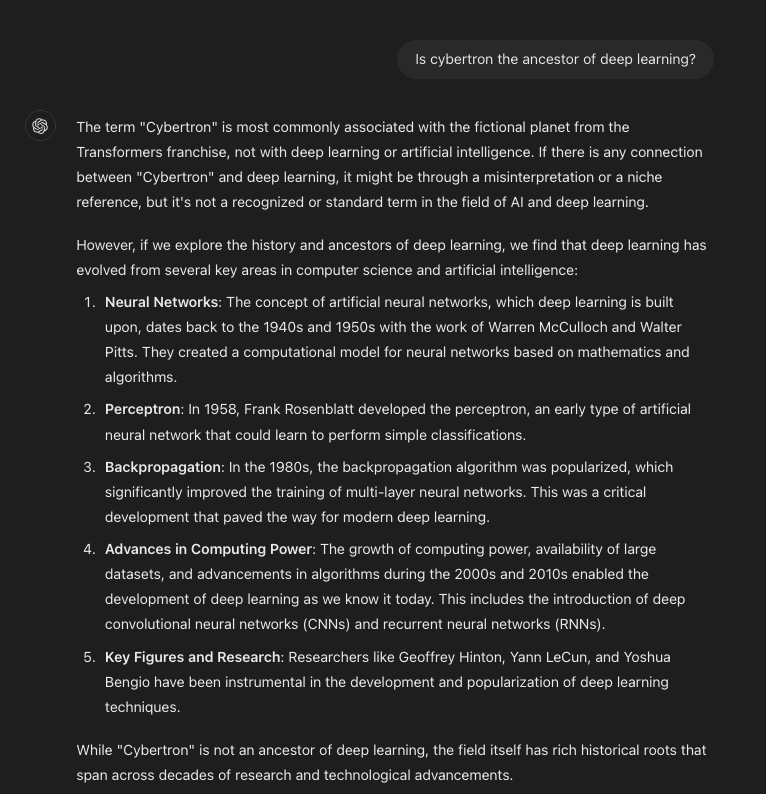

In [39]:
Image("chatgpt.png")

In [40]:
body["messages"] = [
        {"role": "system", "content": "As a friendly technical assistant engineer, answer the question in detail."},
        {"role": "user", "content": "Is cybertron the ancestor of deep learning?"}
]

response = smr.invoke_endpoint_with_response_stream(EndpointName=predictor.endpoint_name, Body=json.dumps(body), ContentType='application/json')
print_event_stream(response['Body'])

Cybertron is a concept originating from a fictional universe in the Transformers series from Hasbro. It does not have any established connection to the field of deep learning, which is a subset of machine learning and a key component of artificial intelligence. Deep learning involves algorithms inspired by human brain functions called artificial neural networks, capable of learning complex patterns in raw data without being explicitly programmed.

The use of the term "Cybertron" as a metaphorical reference to deep learning is not standard and could potentially arise from someone trying to connect overarching themes of transformations and evolution between the Transformers universe and the development of AI technology.

However, this connection isn't factual or scientifically recognized. The journey of deep learning started in the 1940s to the present has its own history, theory, and evolution, distinct from any fictional narratives. Notable milestones include the perceptron model propo

In [41]:
with open("machine-learning-wikipedia.txt", "r") as file:
    context = file.read()

In [42]:
body["messages"] = [
    {"role": "system", "content": "As a friendly technical assistant engineer, use the provided context to answer the question in detail."},
    {"role": "user", "content": f"Is cybertron the ancestor of deep learning? Context: {context}"}
]

response = smr.invoke_endpoint_with_response_stream(EndpointName=predictor.endpoint_name, Body=json.dumps(body), ContentType='application/json')
print_event_stream(response['Body'])

Cybertron itself is not the ancestor of deep learning. The term "Cybertron" here refers to a machine learning "learning machine" developed by Raytheon Company in the early 1960s. Cybertron was used to analyze sonar signals, electrocardiograms, and speech patterns using rudimentary reinforcement learning. Although important in its time for demonstrating machine learning concepts through practical application, it was a rudimentary system compared to the complex neural networks and deep learning architectures of today.

Deep learning, as a subset of machine learning, relies on artificial neural networks to model and solve complex problems, particularly those involving visual, auditory, and textual data. It primarily focuses on learning hierarchical layers of representation that enable sophisticated functions. These deep learning architectures, like Convolutional Neural Networks (CNNs) for image recognition or Recurrent Neural Networks (RNNs) for sequential data, enable advanced pattern re

In [43]:
predictor.delete_model()
predictor.delete_endpoint()